# UAVSAR

```{admonition} Learning Objectives
*A 30 minute guide to UAVSAR data for SnowEX*
- overview of UAVSAR data (both InSAR and PolSAR products)
- demonstrate how to access and transform data
- use Python rasterio and matplotlib to display the data
```

<img src="../../img/UAVSAR_plane.jpg" alt="uavsar airplane" width="800px">

Intro slide deck: https://uavsar.jpl.nasa.gov/education/what-is-uavsar.html 

*Lead developer:  Jack Tarricone, University of Nevada Reno, Other developers: Franz Meyer, University of Alaska Fairbanks and HP Marshall, Boise State University*

In [35]:
# import libraries
import os  # for chdir, getcwd, path.basename, path.exists
import hvplot.xarray
import pandas as pd # for DatetimeIndex 
import rioxarray
import numpy as np #for log10, mean, percentile, power
import rasterio as rio
from rasterio.plot import show # plotting raster data
from rasterio.plot import show_hist #histograms of raster data

import glob # for listing files in tiff conversion function
import matplotlib as mpl
import matplotlib.pyplot as plt # for add_subplot, axis, figure, imshow, legend, plot, set_axis_off, set_data,
                                # set_title, set_xlabel, set_ylabel, set_ylim, subplots, title, twinx

## What is UAVSAR?

UAVSAR stands for uninhabited aerial vehicle synthetic aperture radar. It is a suborbital (airplane) remote sensing instrument operated out of NASA JPL.

| frequency (cm) | resolution (rng x azi m) | swath width (km) |
| - | - | - | 
| L-band 23| 1.8 x 5.5 | 16 | 

Documentation:
* https://uavsar.jpl.nasa.gov/education/what-is-uavsar.html
* https://asf.alaska.edu/data-sets/sar-data-sets/uavsar/
* https://ieeexplore-ieee-org.unr.idm.oclc.org/document/1631770 (Rosen et al. 2006)

## NASA SnowEx 2020 and 2021 UAVSAR Campaings

During the winter of 2020 and 2021, NASA conducted an L-band InSAR timeseris at a seris of sites across the Western US with the goal of tracking changes in SWE. Field teams in 13 different locations in 2020, and in 6 locations in 2021, deployed on the date of the flight to perform calibration and validation observations.

:::{figure-md} UAVSAR-map
<img src="../../img/SnowEx2020.png" alt="uavsar map" width="800px">

Map of the UAVSAR flight locations for NASA SnowEx. Source: Chris Hiemstra
:::

## Data Access

There are multiple ways to access UAVSAR data. Also the SQL database.

* [Alaska Satellite Facility Vertex Portal](https://search.asf.alaska.edu/#/?dataset=UAVSAR)
* [NASA Earthdata Suborbital Search](https://search.earthdata.nasa.gov/portal/suborbital/search?fi=UAVSAR&as[instrument][0]=UAVSAR)
* [JPL UAVSAR Data Search](https://uavsar.jpl.nasa.gov/cgi-bin/data.pl)

```{admonition} InSAR Data Types
:class: InSAR Data Types
- ANN file (.ann): a text annotation file with metadata
- AMP files (.amp1 and .amp2): calibrated multi-looked amplitude products
- INT files (.int): interferogram product, complex number format (we won't be using these here)
- COR files (.cor): interferometric correlation product, a measure of the noise level of the phase
- GRD files (.grd): interferometric products projected to the ground in simple geographic coordinates (latitude, longitude)
- HGT file  (.hgt): the DEM that was used in the InSAR processing
- KML and KMZ files (.kml or .kmz): format for viewing files in Google Earth (can't be used for analysis)
```

### Data Download

We will use our NASA EarthData credentials and ASF Vertex to download an InSAR pair data into our notebook directly. For this tutorial, we will be working with UAVSAR data from February of 2020. If you want to use different data in the future, change the links in the files variable. The screengrab below shows how I generated these download links from the ASF site.

:::{figure-md} vertex
<img src="../../img/asf_vertex.png" alt="asf vertex" width="800px">

Screenshot of ASF Vertex interface
:::

:::{note}
For efficiency, we've already downloaded and converted UAVSAR to a GIS-friendly Geotiff format for this tutorial. See the additional notebook for code and documentation: [uavsar-download.ipynb](./uavsar-download.ipynb)
:::

In [10]:
# Change to tmp directory and download staged tutorial data
os.chdir('/tmp')

!aws s3 cp --no-progress s3://snowex-data/tutorial-data/sar/uavsar/ .  --recursive --exclude "*" --include "*tiff"

download: s3://snowex-data/tutorial-data/sar/uavsar/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.hgt.grd.tiff to ./grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.hgt.grd.tiff
download: s3://snowex-data/tutorial-data/sar/uavsar/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.amp1.grd.tiff to ./grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.amp1.grd.tiff
download: s3://snowex-data/tutorial-data/sar/uavsar/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.amp2.grd.tiff to ./grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.amp2.grd.tiff
download: s3://snowex-data/tutorial-data/sar/uavsar/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.cor.grd.tiff to ./grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.cor.grd.tiff
download: s3://snowex-data/tutorial-data/sar/uavsar/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.unw.grd.tiff to ./grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.unw.grd.tiff
download: s3://snowex-data/tutorial-data/sar/uavsar

In [120]:
for amp1HH in glob.glob("grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.amp1.grd.tiff"):
    print(amp1HH)
for amp1HV in glob.glob("grmesa_27416_20003-028_20005-007_0011d_s01_L090HV_01.amp1.grd.tiff"):
     print(amp1HV)
for amp1VH in glob.glob("grmesa_27416_20003-028_20005-007_0011d_s01_L090VH_01.amp1.grd.tiff"):
     print(amp1VH)
for amp1VV in glob.glob("grmesa_27416_20003-028_20005-007_0011d_s01_L090VV_01.amp1.grd.tiff"):
     print(amp1VV)
        
for amp2HH in glob.glob("grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.amp2.grd.tiff"):
     print(amp2HH)
for amp2VV in glob.glob("grmesa_27416_20003-028_20005-007_0011d_s01_L090VV_01.amp2.grd.tiff"):
     print(amp2VV)
for amp2HV in glob.glob("grmesa_27416_20003-028_20005-007_0011d_s01_L090HV_01.amp2.grd.tiff"):
     print(amp2HV)
for amp2VH in glob.glob("grmesa_27416_20003-028_20005-007_0011d_s01_L090VH_01.amp2.grd.tiff"):
     print(amp2VH)

    
for corrHH in glob.glob("grmesa_27416_21019-017_21021-005_0006d_s01_L090HH_01.cor.grd.tiff"):
    print(corrHH)
for corrHH2 in glob.glob("grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.cor.grd.tiff"):
    print(corrHH2)
for corrHV in glob.glob("grmesa_27416_20003-028_20005-007_0011d_s01_L090HV_01.cor.grd.tiff"):
    print(corrHV)
for corrVV in glob.glob("grmesa_27416_20003-028_20005-007_0011d_s01_L090VV_01.cor.grd.tiff"):
    print(corrVV)
for corrVH in glob.glob("grmesa_27416_20003-028_20005-007_0011d_s01_L090VH_01.cor.grd.tiff"):
    print(corrVH)

for unwHH in glob.glob("grmesa_27416_21019-017_21021-005_0006d_s01_L090HH_01.unw.grd.tiff"):
    print(unwHH)
for unwHH2 in glob.glob("grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.unw.grd.tiff"):
    print(unwHH2)
for unwHV in glob.glob("grmesa_27416_20003-028_20005-007_0011d_s01_L090HV_01.unw.grd.tiff"):
    print(unwHV)
for unwVV in glob.glob("grmesa_27416_20003-028_20005-007_0011d_s01_L090VV_01.unw.grd.tiff"):
    print(unwVV)
for unwVH in glob.glob("grmesa_27416_20003-028_20005-007_0011d_s01_L090VH_01.unw.grd.tiff"):
    print(unwVH)
    
for demHH in glob.glob("grmesa_27416_21019-017_21021-005_0006d_s01_L090HH_01.hgt.grd.tiff"):
    print(demHH)
for demHH2 in glob.glob("grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.hgt.grd.tiff"):
    print(demHH2)
for demHV in glob.glob("grmesa_27416_20003-028_20005-007_0011d_s01_L090HV_01.hgt.grd.tiff"):
    print(demHV)
for demVV in glob.glob("grmesa_27416_20003-028_20005-007_0011d_s01_L090VV_01.hgt.grd.tiff"):
    print(demVV)
for demVH in glob.glob("grmesa_27416_20003-028_20005-007_0011d_s01_L090VH_01.hgt.grd.tiff"):
    print(demVH)

grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.amp1.grd.tiff
grmesa_27416_20003-028_20005-007_0011d_s01_L090HV_01.amp1.grd.tiff
grmesa_27416_20003-028_20005-007_0011d_s01_L090VH_01.amp1.grd.tiff
grmesa_27416_20003-028_20005-007_0011d_s01_L090VV_01.amp1.grd.tiff
grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.amp2.grd.tiff
grmesa_27416_20003-028_20005-007_0011d_s01_L090VV_01.amp2.grd.tiff
grmesa_27416_20003-028_20005-007_0011d_s01_L090HV_01.amp2.grd.tiff
grmesa_27416_20003-028_20005-007_0011d_s01_L090VH_01.amp2.grd.tiff
grmesa_27416_21019-017_21021-005_0006d_s01_L090HH_01.cor.grd.tiff
grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.cor.grd.tiff
grmesa_27416_20003-028_20005-007_0011d_s01_L090HV_01.cor.grd.tiff
grmesa_27416_20003-028_20005-007_0011d_s01_L090VV_01.cor.grd.tiff
grmesa_27416_20003-028_20005-007_0011d_s01_L090VH_01.cor.grd.tiff
grmesa_27416_21019-017_21021-005_0006d_s01_L090HH_01.unw.grd.tiff
grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.unw.grd.tiff
gr

Inspect the meta data the rasters using the rio (shorthand for rasterio) ```profile``` function.

In [19]:
unwHH_rast = rio.open(unwHH)
meta_data = unwHH_rast.profile
print(meta_data)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 7002, 'height': 4767, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(5.556e-05, 0.0, -108.30183012,
       0.0, -5.556e-05, 39.19019052), 'tiled': False, 'interleave': 'band'}


## Opening and plotting the raw UAVSAR raster files
We now have our five different data sets: the two amplitude files, coherence, unwrapped phased, and the DEM. We will not be working the actual interferogram (.int) file because it contains complex numbers that don't work in the Python packages being used.

Here we will open a raster files using the ```rio.open()``` function. We'll then create a simple plot using the ```rio``` ```show()``` function.

### Amp 1, Amp 2, Coherence and Unwrapped phase

In [105]:
amp1HH_rast = rio.open(amp1HH)
amp2HH_rast = rio.open(amp2HH)
corrHH_rast = rio.open(corrHH)
unwHH_rast = rio.open(unwHH)
corrHH2_rast = rio.open(corrHH2)
unwHH2_rast = rio.open(unwHH2)#open raster
fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(10,8)) #define figure size
show((amp1HH_rast,1),ax=axr, cmap = 'Blues', vmin = 0, vmax = 0.4, title='Amplitude 1 - HH')
show((corrHH_rast,1),ax=axg, cmap = 'inferno', vmin = 0, vmax = 1, title='Coherence - HH')
show((corrHH2_rast,1),ax=axb, cmap = 'inferno', vmin = 0, vmax = 1, title='Coherence 2 - HH')
plt.show()

In [114]:
fig, (axf, axl, axs) = plt.subplots(1,3, figsize=(10,8))
show((amp2HH_rast,1),ax=axf, cmap = 'Reds', vmin = 0, vmax = 0.5, title='Amplitude 2 - HH')
show((unwHH_rast,1), ax=axl,  cmap = 'viridis', vmin = 0, vmax = 1, title='Unwrapped Phase - HH')
show((unwHH2_rast,1),ax=axs,  cmap = 'viridis', vmin = 0, vmax = 1, title='Unwrapped Phase 2 - HH')
plt.show()

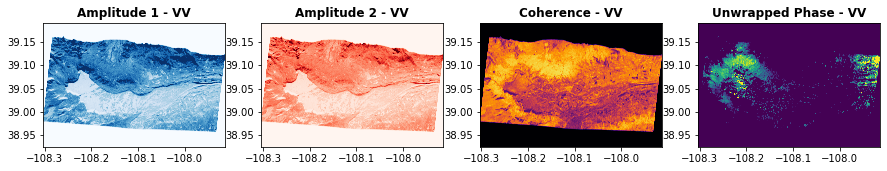

In [108]:
amp1VV_rast = rio.open(amp1VV)
amp2VV_rast = rio.open(amp2VV)
corrVV_rast = rio.open(corrVV)
unwVV_rast = rio.open(unwHV)
fig, (axr, axg, axb, axf) = plt.subplots(1,4, figsize=(15,10)) #define figure size
show((amp1VV_rast,1),ax=axr, cmap = 'Blues', vmin = 0, vmax = 0.4, title='Amplitude 1 - VV')
show((amp2VV_rast,1),ax=axg, cmap = 'Reds', vmin = 0, vmax = 0.5, title='Amplitude 2 - VV')
show((corrVV_rast,1),ax=axb, cmap = 'inferno', vmin = 0, vmax = 1, title='Coherence - VV')
show((unwVV_rast,1), ax=axf,  cmap = 'viridis', vmin = 0, vmax = 1, title='Unwrapped Phase - VV')
plt.show()

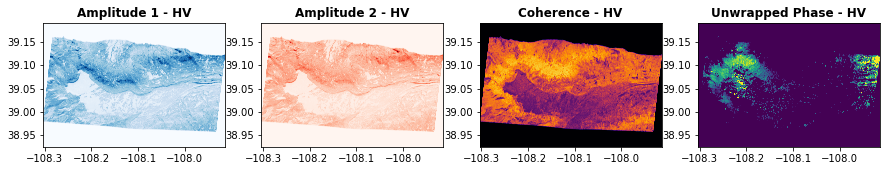

In [117]:
amp1HV_rast = rio.open(amp1HV)
amp2HV_rast = rio.open(amp2HV)
corrHV_rast = rio.open(corrHV)
unwHV_rast = rio.open(unwHV)
fig, (axr, axg, axb, axf) = plt.subplots(1,4, figsize=(15,10)) #define figure size
show((amp1HV_rast,1),ax=axr, cmap = 'Blues', vmin = 0, vmax = 0.3, title='Amplitude 1 - HV')
show((amp2HV_rast,1),ax=axg, cmap = 'Reds', vmin = 0, vmax = 0.4, title='Amplitude 2 - HV')
show((corrHV_rast,1),ax=axb, cmap = 'inferno', vmin = 0, vmax = 1, title='Coherence - HV')
show((unwHV_rast,1), ax=axf,  cmap = 'viridis', vmin = 0, vmax = 1, title='Unwrapped Phase - HV')
plt.show()

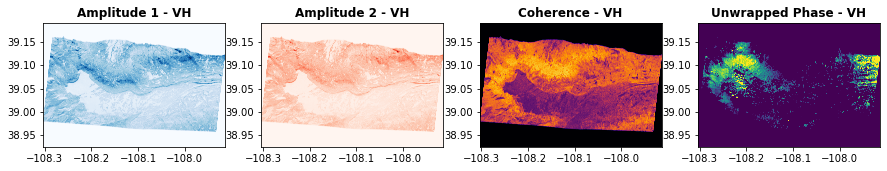

In [118]:
amp1VH_rast = rio.open(amp1VH)
amp2VH_rast = rio.open(amp2VH)
corrVH_rast = rio.open(corrVH)
unwVH_rast = rio.open(unwVH)
fig, (axr, axg, axb, axf) = plt.subplots(1,4, figsize=(15,10)) #define figure size
show((amp1VH_rast,1),ax=axr, cmap = 'Blues', vmin = 0, vmax = 0.3, title='Amplitude 1 - VH')
show((amp2VH_rast,1),ax=axg, cmap = 'Reds', vmin = 0, vmax = 0.4, title='Amplitude 2 - VH')
show((corrVH_rast,1),ax=axb, cmap = 'inferno', vmin = 0, vmax = 1, title='Coherence - VH')
show((unwVH_rast,1), ax=axf,  cmap = 'viridis', vmin = 0, vmax = 1, title='Unwrapped Phase - VH')
plt.show()

### DEM
Now we'll make a quick histogram using ```rio``` ```show_hist()``` to check what we should set the bounds of the color scale to.

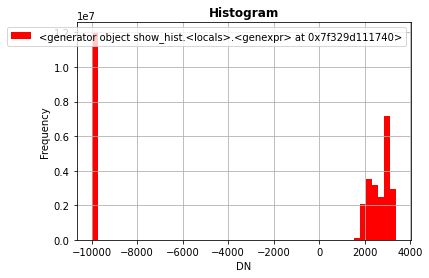

In [126]:
demHH_rast = rio.open(demHH)
show_hist(dem_rast, bins = 50)

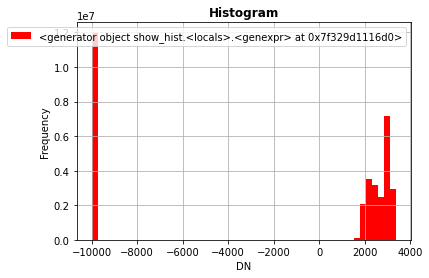

In [127]:
demHH2_rast = rio.open(demHH2)
show_hist(dem_rast, bins = 50)

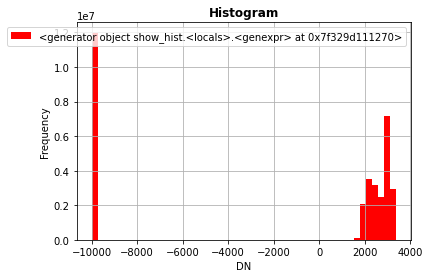

In [128]:
demVV_rast = rio.open(demVV)
show_hist(dem_rast, bins = 50)

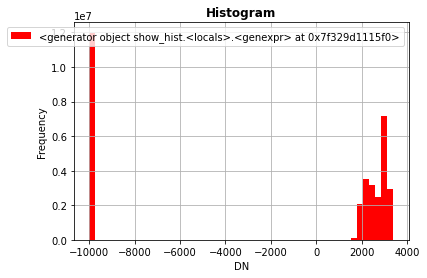

In [129]:
demHV_rast = rio.open(demHV)
show_hist(dem_rast, bins = 50)

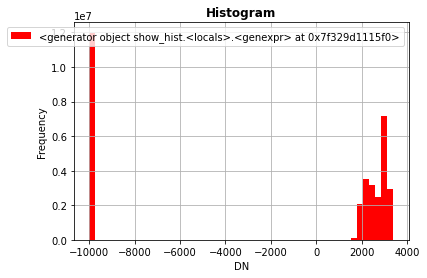

In [130]:
demVH_rast = rio.open(demVH)
show_hist(dem_rast, bins = 50)

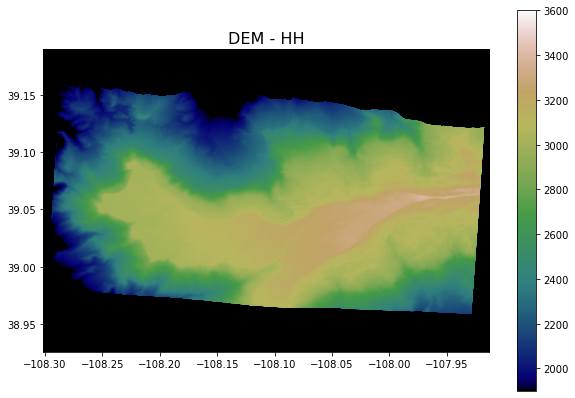

In [152]:
fig, ax = plt.subplots(figsize = (10,7))
ax.set_title("DEM - HH", fontsize= 16)
norm = mpl.colors.Normalize(vmin = 1900, vmax = 3600)
# creating ScalarMappable
sm = plt.cm.ScalarMappable(cmap='gist_earth', norm=norm)
sm.set_clim([1900,3600])
plt.colorbar(sm)
show((demHH_rast, 1), cmap = 'gist_earth', vmin = 1900, vmax = 3600); 
plt.show()

## Formatting the data for visualization
The plots of the raw data need some work. Some fotmatting is necessary to visualize the data clearly. UAVSAR uses "0" as it's no data value (not the best practice in general) for amplitude, coherence, and unwrapped phase. For the DEM -10000 is the no data value. Using -9999 or another value that is obviously not actual data is a better practice with spatial data to limit confusion. We'll convert these no data values to NaN (Not a Number) which will remove the boarders around data, and in data lost the unwrapping in the UNW file.

### Amplitude formatting
For the two amplitude files we need to do two things. Convert from the linear amplitude scale to decibel (dB) and change the 0 values to NaN. To do this we'll convert our raster file to an ```np.array``` to manipulate it. Note that when we convert the raster data to an array, the spatial coordinates are lost and it no longer plots the x and y scales at longitude and latitude values. For our purposes this okay, but you would need to convert back to a .tiff if you wanted to save the file to use in ArcGIS or QGIS.

In [40]:
# amp1 
# open raster as a data array
with rio.open(amp1) as amp1_raw:
    amp1_array = amp1_raw.read(1) #open raster as an array

# convert all 0's to nan
amp1_array[amp1_array == 0] = np.nan # convert all 0's to NaN's

# convert to dB
amp1_dB = 10.0 * np.log10(amp1_array) # convert to the dB scale

# amp2 
with rio.open(amp2) as amp2_raw:
    amp2_array = amp2_raw.read(1)
    
amp2_array[amp2_array == 0] = np.nan

amp2_dB = 10.0 * np.log10(amp2_array)

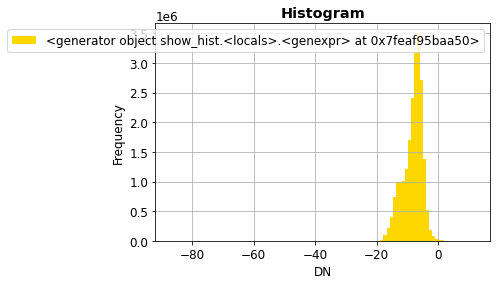

In [41]:
show_hist(amp2_dB, bins = 100)

Instead of using the ```rio.show()``` function, we'll try out the ```matplotlib``` (we are calling ```plt```) ```im.show()``` style of plotting to implement a color scale.

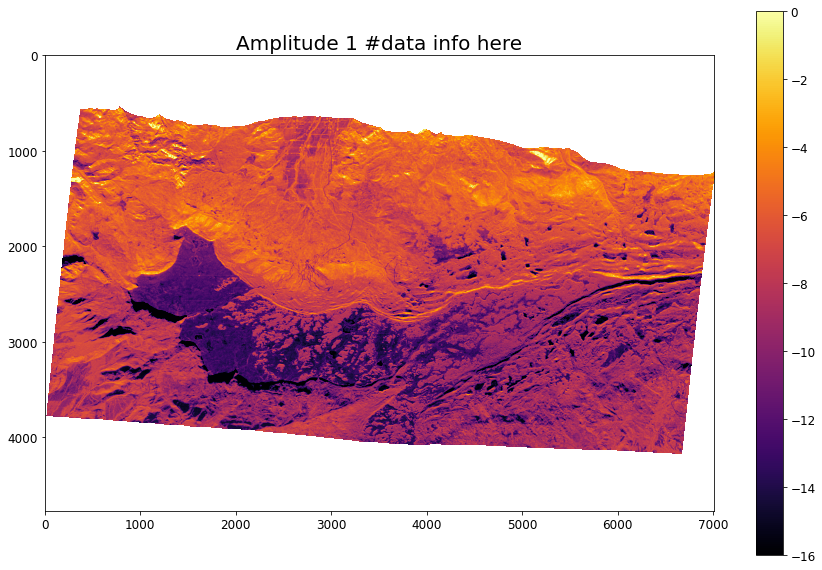

In [42]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.set_title("Amplitude 1 #data info here", fontsize= 20) #title and font size
amp2_plot = ax.imshow(amp2_dB, cmap='inferno',vmin=-16, vmax=0) #set bounds and color map

# add legend
colorbar = fig.colorbar(amp2_plot, ax=ax) #add color bar
plt.show()

Now we'll create a function called ```show_two_images()``` to plot two images at once. The function inputs are a data array, color map name, and a plot title for both images. It uses ```np.nanpercentile()``` to automatically set the color scale bounds, but you can also set them manually.

In [43]:
# function for showing two images using matplotlib
plt.rcParams.update({'font.size': 12}) # set fontsize
def show_two_images(img1, img2, col1, col2, title1, title2, vmin1=None, vmax1=None, vmin2=None, vmax2=None):

    fig = plt.figure(figsize=(20, 20))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    # auto setting axis limits
    if vmin1 == None:
        vmin1 = np.nanpercentile(img1, 1)
    if vmax1 == None:
        vmax1 = np.nanpercentile(img1, 99)
    
    # plot image
    masked_array1 = np.ma.array(img1, mask=np.isnan(0)) #mask for 0
    plt1 = ax1.imshow(masked_array1, cmap=col1, vmin=vmin1, vmax=vmax1, interpolation = 'nearest') #fixes NaN problem
    ax1.set_title(title1)
    ax1.xaxis.set_label_text('Linear stretch Min={} Max={}'.format(vmin1, vmax1))
        
    # add color scale
    colorbar = fig.colorbar(plt1, ax=ax1, fraction=0.03, pad=0.04)
    
     # auto setting axis limits
    if vmin2 == None:
        vmin2 = np.nanpercentile(img2, 1)
    if vmax2 == None:
        vmax2 = np.nanpercentile(img2, 99)
    
    # plot image
    masked_array2 = np.ma.array(img2, mask=np.isnan(0)) #mask for 0
    plt2 = ax2.imshow(masked_array2, cmap=col2, vmin=vmin2, vmax=vmax2, interpolation = 'nearest')
    ax2.set_title(title2)
    ax2.xaxis.set_label_text('Linear stretch Min={} Max={}'.format(vmin2, vmax2))
    colorbar = fig.colorbar(plt2, ax=ax2, fraction=0.03, pad=0.04)
    plt.show()


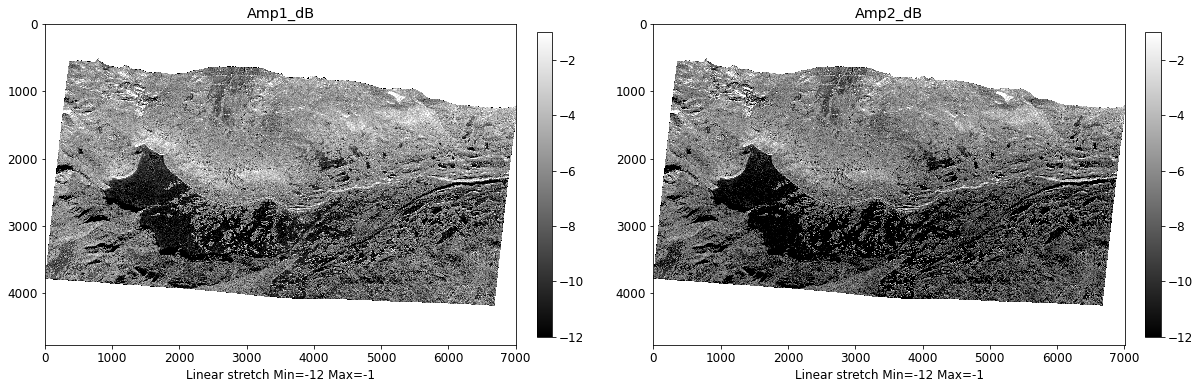

In [44]:
# plot both amplitude images

show_two_images(amp1_dB, amp2_dB, 'gray', 'gray', 'Amp1_dB', 'Amp2_dB', -12,-1,-12,-1)

### Coherence, Unwrapped Phase, DEM
For these three data types, we only need to convert no data values (0) to NaN.

In [45]:
with rio.open(cor) as cor_raw:
    cor_array = cor_raw.read(1)

cor_array[cor_array == 0] = np.nan # convert all 0's to nan

# unw
with rio.open(unw) as unw_raw:
    unw_array = unw_raw.read(1)
    
unw_array[unw_array == 0] = np.nan

# dem
with rio.open(dem) as dem_raw:
    dem_array = dem_raw.read(1)
    
dem_array[dem_array == -10000] = np.nan #different no data value

Checking to see if it worked by comparing ```unw_rast``` which still includes 0's to ```unw_array``` where we changed them to NaN.

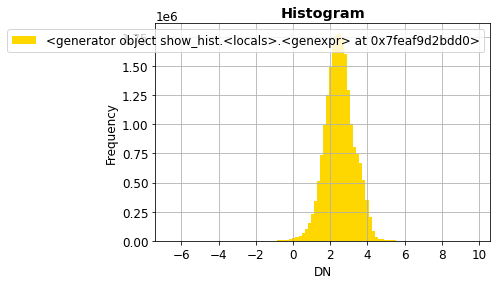

In [46]:
show_hist(unw_rast, bins = 100) 
show_hist(unw_array, bins = 100)

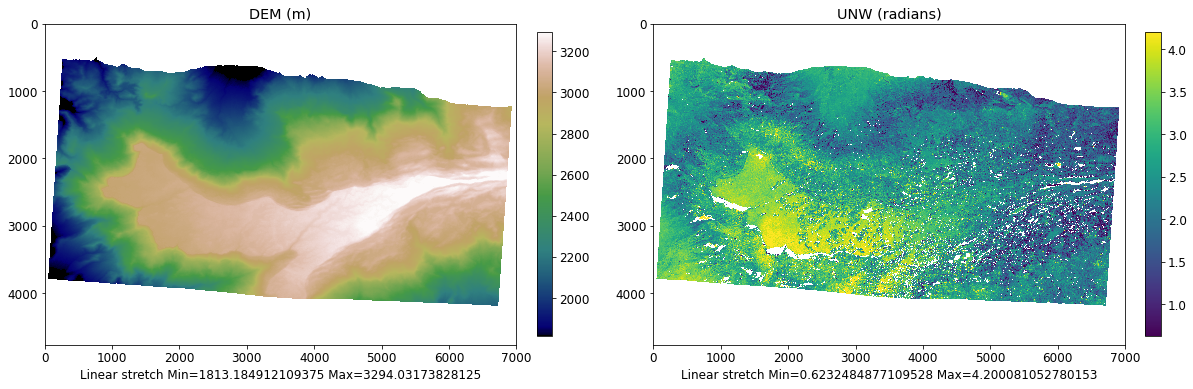

In [47]:
plt.rcParams.update({'font.size': 12}) # set fontsize
show_two_images(dem_array, unw_array, 'gist_earth', 'viridis', 'DEM (m)', 'UNW (radians)')

Let's plot the UNW raster larger so we can get a better look at the detail.

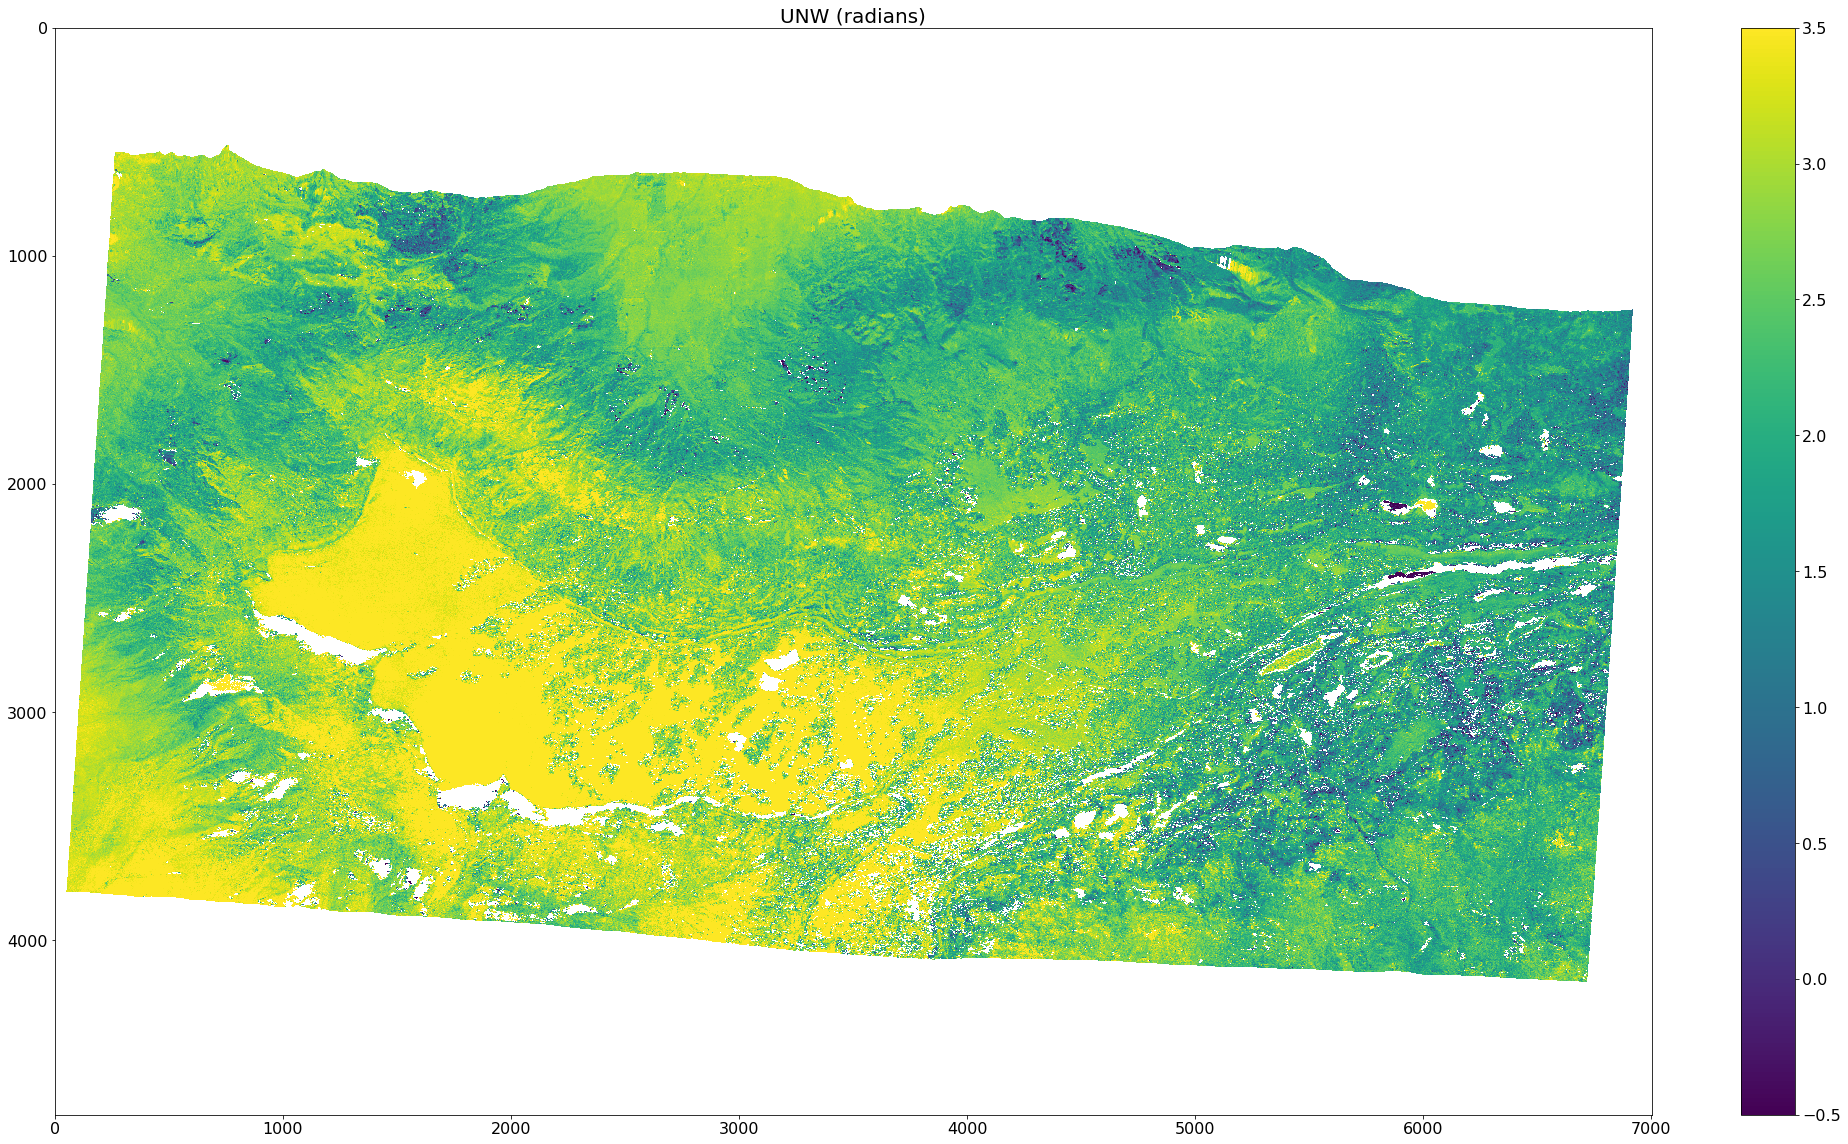

In [56]:
plt.rcParams.update({'font.size': 16}) # increase plot font size for larger plot
fig, ax = plt.subplots(figsize=(40, 20))

masked_array = np.ma.array(unw_array, mask = np.isnan(0)) # mask for 0
ax.set_title("UNW (radians)", fontsize= 20) #title and font size
img = ax.imshow(masked_array, cmap = 'viridis', interpolation = 'nearest', vmin = -0.5, vmax =3.5)

# add legend
colorbar = fig.colorbar(img, ax=ax, fraction=0.03, pad=0.04) # add color bar
plt.show()
plt.rcParams.update({'font.size': 12}) # change font back to normal

 This looks **much** better! Plotting the image at a larger scale allows us to see an accurate representation of the data.

## LiDAR depth change vs InSAR Phase change Comparison
The SnowEx 2020 campaign conducted a pair of LiDAR and InSAR flights over Grand Mesa on February 1st and 13th. The purpose of the paired data collected was to test the UAVSAR L-band InSAR SWE/Depth change technique against the LiDAR depth change retrievals. LiDAR is proven to work exceptionally well for measuring snow depth changes, so this provides an opportunity to validate the InSAR data.

In [49]:
!aws s3 cp --no-progress s3://snowex-data/tutorial-data/sar/gmesa_depth_change_02-01_02-13.tif /tmp/gmesa_depth_change_02-01_02-13.tif

download: s3://snowex-data/tutorial-data/sar/gmesa_depth_change_02-01_02-13.tif to ./gmesa_depth_change_02-01_02-13.tif


In [50]:
lidar_dc = '/tmp/gmesa_depth_change_02-01_02-13.tif' #path to lidar depth change raster

# print meta data, and check to see if the raster has a no data value
lidar_rast = rio.open(lidar_dc)
meta_data = lidar_rast.profile
print(meta_data)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4e+38, 'width': 7576, 'height': 3528, 'count': 1, 'crs': CRS.from_epsg(32612), 'transform': Affine(3.0, 0.0, 737454.0,
       0.0, -3.0, 4330218.0), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


We can see this raster has a no data value of ```'nodata': -3.4e+38``` set (most of the UAVSAR ones did not). Therefore we can read it in with the ```masked=TRUE``` command to automatically mask out the no data pixels.

In [51]:
with rio.open(lidar_dc) as dataset:
    lidar_masked = dataset.read(1, masked=True)

In [52]:
# quick test plot
fig, ax = plt.subplots(figsize = (30,8))
ax.set_title("LiDAR Depth Change",fontsize = 16);
show((lidar_masked), cmap = 'RdBu', vmin = -.3, vmax = .3)

<AxesSubplot:title={'center':'LiDAR Depth Change'}>

## LiDAR vs UNW
Using ```show_two_images()```, we can plot the LiDAR depth change and UNW images next to each other to compare them.

In [53]:
show_two_images(lidar_masked, unw_array, 'RdBu', 'RdBu', 'LiDAR Depth Change (cm)', 'UNW (radians)', vmin1 = -.3, vmax1 = .3, vmin2=-4, vmax2=6)

The two rasters cover different areas, are different resolutions, and have different missing pixels. Let's zoom into the top left corner of Grand Mesa where there was significant wind drifting to compare the two data sets.

In [54]:
show_two_images(lidar_masked[700:1700,700:1700], unw_array[2150:2750,1300:1900], 
                'RdBu', 'RdBu', 'LiDAR Depth Change (cm)', 'UNW (radians)', vmin1 = -.3, vmax1 = .3, vmin2=-4, vmax2=6)

As you can see in the two plots above, there is a very strong spatial relationship between LiDAR depth change and InSAR change in phase. This relationship is the basis of measuring changes in SWE using L-band InSAR. While we don't get into the next step of converting phase change to SWE or depth change from InSAR, we will get into that in the UAVSAR project!